<a href="https://colab.research.google.com/github/mateuslatrova/correcao-enem/blob/main/cluster_of_words_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup para o Google Colab

In [1]:
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir("/content/drive/MyDrive/")
os.getcwd()

'/content/drive/MyDrive'

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
! git clone https://github.com/mateuslatrova/correcao-enem.git

fatal: destination path 'correcao-enem' already exists and is not an empty directory.


In [4]:
os.chdir("/content/drive/MyDrive/correcao-enem")
os.getcwd()

'/content/drive/MyDrive/correcao-enem'

In [8]:
! git pull

Updating dd9430a..409c0ea
Fast-forward
 correction/cluster_of_words/config.yaml      |   2 +-
 correction/cluster_of_words/plotter.py       |   5 +-
 correction/topic_deviation/fine_tuner.py     | 228 ++++++++++++++++++++++++++---------
 correction/topic_deviation/neural_network.py |  34 ++++++
 poster.tex                                   | 304 +++++++++++++++++++++++++++++++++++++++++++++++
 5 files changed, 514 insertions(+), 59 deletions(-)
 create mode 100644 correction/topic_deviation/neural_network.py
 create mode 100644 poster.tex


In [9]:
# requirements on Google Colab:
!pip install -r colab_requirements.txt

ERROR: Operation cancelled by user


### Imports

In [ ]:
import os
while os.path.basename(os.getcwd()) != "correcao-enem":
    os.chdir("..")

In [10]:
from correction.cluster_of_words.chunks_divider import EssayChunksDivider
from correction.cluster_of_words.evaluator import ClusterOfWordsEvaluator
from correction.cluster_of_words.perplexity_calculator import PerplexityCalculator
from correction.cluster_of_words.plotter import PlotterForClusterOfWords
from correction.cluster_of_words.preprocessor import EssayDatasetPreprocessorForClusterOfWords
from correction.config_reader.config_reader import ConfigReader

from datasets import (
    load_dataset,
)

### Variáveis globais

In [11]:
config_path = "correction/cluster_of_words/config.yaml"
config_reader = ConfigReader(config_path)

## Pré-processamento das redações para o experimento do aglomerado de palavras

In [12]:
raw_dataset_dict = load_dataset("csv", data_files=config_reader.get_train_raw_dataset_path())
raw_dataset_dict

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'id_prompt', 'title', 'essay', 'grades', 'final_grade', 'is_ENEM', 'is_convertible', 'general', 'specific'],
        num_rows: 385
    })
})

In [13]:
train_dataset = raw_dataset_dict["train"]
train_dataset

Dataset({
    features: ['id', 'id_prompt', 'title', 'essay', 'grades', 'final_grade', 'is_ENEM', 'is_convertible', 'general', 'specific'],
    num_rows: 385
})

In [14]:
columns_to_remove = [
    "id_prompt",
    "title",
    "grades",
    "final_grade",
    "is_ENEM",
    "is_convertible",
    "general",
    "specific",
]
preprocessor = EssayDatasetPreprocessorForClusterOfWords(train_dataset, columns_to_remove=columns_to_remove)
preprocessed_dataset_dict = preprocessor.preprocess_dataset()
preprocessed_dataset_dict

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

Map:   0%|          | 0/385 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['essay_id', 'essay_text', 'second_grade'],
        num_rows: 385
    })
})

In [15]:
preprocessed_dataset_dict.save_to_disk(config_reader.get_preprocessed_dataset_path())

Saving the dataset (0/1 shards):   0%|          | 0/385 [00:00<?, ? examples/s]

## Experimento 1: medir a perplexidade por redação
#### Obs.: nesse caso, apenas os 512 primeiros tokens de cada redação são considerados devido à limitação do modelo BERT

In [16]:
checkpoint = config_reader.get("checkpoint")
perplexity_calculator = PerplexityCalculator(checkpoint)

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
dataset = preprocessed_dataset_dict["train"]
dataset.set_format("pandas")
df = dataset[:]
df

,essay_id,essay_text,second_grade
0,0,Com os avanços que a sociedade deu em tecnolog...,200
1,1,"De acordo com pesquisas, o Brasil é o país da ...",120
2,2,Em uma pesquisa recente realizada pela ONG Oxf...,80
3,3,"A ideia de vencer na vida, presente no imaginá...",200
4,4,O caminho do sucessoÉ de fundamental importânc...,80
...,...,...,...
380,809,"A descoberta do fogo pelo homem, ocasionou a R...",80
381,810,Em contraponto às conquistas do Renascimento C...,120
382,811,Rene Descartes e Galileu Galilei são duas figu...,120
383,812,É notório o aumento da discussão acerca da inf...,120


In [18]:
df = perplexity_calculator.calculate_perplexity_for_all_essays(df)
df

  0%|          | 0/385 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,essay_id,essay_text,second_grade,perplexity
0,206,É notório que os direitos em conflitos devem s...,0,1.499978e-08
1,674,O supremo tribunal federal é definido como um ...,0,3.894709e-08
2,317,A escravidão é algo que não está destacado na ...,0,4.650690e-08
3,282,Atualmente é muito discutido um problema na qu...,0,7.448215e-08
4,683,De acordo com pesquisas o supremo tribunal fed...,0,8.050814e-08
...,...,...,...,...
380,157,"Desde a pré-história, o homem sempre se utiliz...",200,3.512533e-07
381,260,Os hábitos alimentares são culturais e represe...,200,3.784702e-07
382,586,"Com apenas 20 anos de idade, o poeta romântico...",200,4.317771e-07
383,150,A humanidade está fadada a superar seus limite...,200,6.687188e-07


In [19]:
plotter = PlotterForClusterOfWords()
plotter

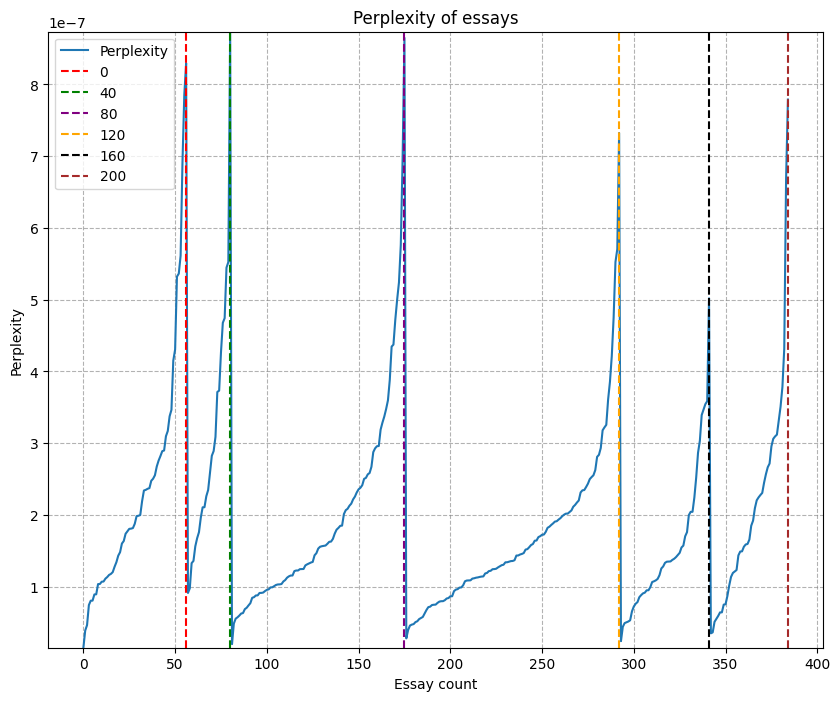

In [20]:
plotter.plot_perplexity_for_each_essay(df)

In [21]:
df

,essay_id,essay_text,second_grade,perplexity
0,206,É notório que os direitos em conflitos devem s...,0,1.499978e-08
1,674,O supremo tribunal federal é definido como um ...,0,3.894709e-08
2,317,A escravidão é algo que não está destacado na ...,0,4.650690e-08
3,282,Atualmente é muito discutido um problema na qu...,0,7.448215e-08
4,683,De acordo com pesquisas o supremo tribunal fed...,0,8.050814e-08
...,...,...,...,...
380,157,"Desde a pré-história, o homem sempre se utiliz...",200,3.512533e-07
381,260,Os hábitos alimentares são culturais e represe...,200,3.784702e-07
382,586,"Com apenas 20 anos de idade, o poeta romântico...",200,4.317771e-07
383,150,A humanidade está fadada a superar seus limite...,200,6.687188e-07


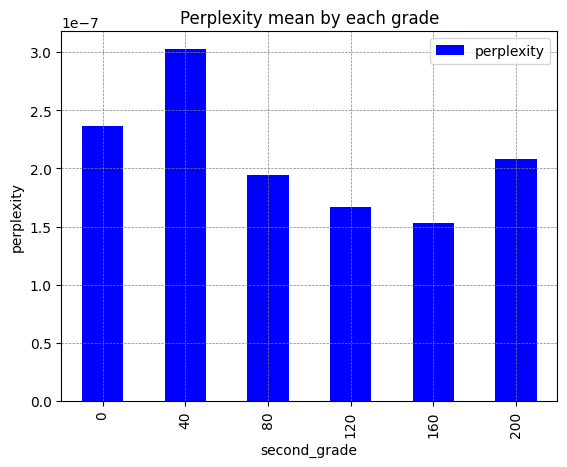

In [23]:
mean_by_grade_df = perplexity_calculator.calculate_perplexity_mean_for_each_grade(df)
plotter.plot_perplexity_mean_for_each_grade(mean_by_grade_df)

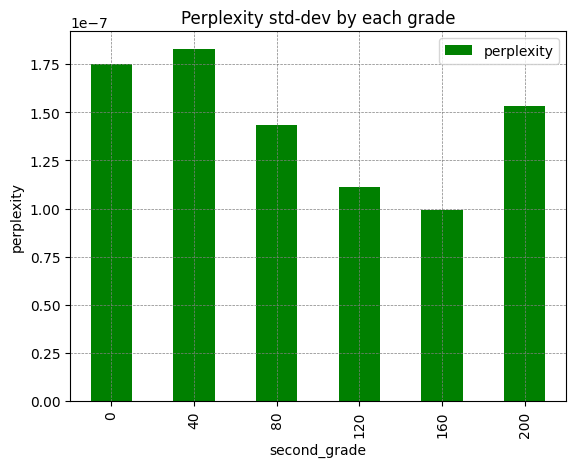

In [24]:
std_dev_by_grade_df = perplexity_calculator.calculate_perplexity_std_dev_for_each_grade(df)
plotter.plot_perplexity_std_dev_for_each_grade(std_dev_by_grade_df)

## Experimento 2: dividir cada redação em chunks, calcular a perplexidade de cada chunk, e considerar a perplexidade da redação como sendo a MÉDIA das perplexidades dos seus chunks.

In [25]:
chunk_sizes = [2048, 1024, 512]
chunks_dfs = []
chunks_divider = EssayChunksDivider()

In [ ]:
for chunk_size in chunk_sizes:
    chunks_df = chunks_divider.get_chunks_df(df, chunk_size)
    chunks_df = perplexity_calculator.calculate_perplexity_for_all_essays(chunks_df)
    chunks_dfs.append(chunks_df)

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/831 [00:00<?, ?it/s]

  0%|          | 0/1440 [00:00<?, ?it/s]

In [ ]:
for chunks_df in chunks_dfs:
  mean_df = perplexity_calculator.calculate_perplexity_for_all_essays_using_chunks_mean(chunks_df)
  plotter.plot_perplexity_for_each_essay(mean_df)

## Experimento 3: dividir cada redação em chunks, calcular a perplexidade de cada chunk, e considerar a perplexidade da redação como sendo a SOMA das perplexidades dos seus chunks.

In [ ]:
for chunks_df in chunks_dfs:
  sum_df = perplexity_calculator.calculate_perplexity_for_all_essays_using_chunks_sum(chunks_df)
  plotter.plot_perplexity_for_each_essay(sum_df)

## Processo de avaliação de uma redação quanto a ser ou não um aglomerado de palavras

Primeiro, vale ressaltar que a estratégia escolhida para esta avaliação é a do primeiro experimento, pois foi ela que mostrou a maior diferença entre a perplexidade das redações do nível 1(prováveis aglomerados de palavras) e as demais.

A ideia da avaliação é que, dado o texto de uma redação, calculamos a sua perplexidade, e caso essa perplexidade esteja num certo intervalo(que definiremos a seguir), podemos afirmar com uma determinada confiança que a nota dessa redação para a competência 2 é 40, e que provavelmente ela é um aglomerado de palavras.

### Cálculo dos intervalo de confiança da perplexidade de redações de nível 1 (nota 40)

---



In [ ]:
grade_40_df = df[df["second_grade"] == 40]
grade_40_df

In [ ]:
confidence_levels = [0.75, 0.8, 0.85, 0.9]

confidence_intervals = perplexity_calculator.calculate_confidence_intervals(grade_40_df,confidence_levels)

### O intervalo de perplexidade para o qual uma redação é considerada um aglomerado de palavras será (a, +inf), em que a é *a* é o limite inferior de um dos intervalos de confiança calculados acima. O limite superior deste intervalo será +inf, pois quanto maior a perplexidade da redação, maior a probabilidade de que ela seja um aglomerado.

In [ ]:
plotter.plot_confusion_matrix_for_confidence_intervals(df[df["second_grade"] != 0], confidence_intervals)

Observando as matrizes de confusão acima, podemos concluir que o melhor intervalo a ser utilizado é o de confiança = 75%, pois foi ele que teve a melhor acurácia, tanto para as redações que possuem nota 40, quanto para as demais.

Para as redações de nota 40, houve um acerto de 50%.
Já para as demais, o acerto foi de 78%.

In [32]:
cluster_indexes = [
    190,
    488, # trechos com aglomerado
    492,
    743,
    488,
    612, # trechos
    802,
    404, # dvida
    8
]

In [33]:
df[df["essay_id"].isin(cluster_indexes)]

,essay_id,essay_text,second_grade,perplexity
61,743,Há alguns dias os jovens estão passando por um...,40,1.563128e-07
67,492,Sabemos que o aquecimento global com essa muda...,40,2.260962e-07
73,190,A nova moeda digital vem tendo um grande conhe...,40,3.714180e-07
76,488,"Atualmente com o aquecimento global aumentado,...",40,4.677943e-07
77,612,"Em 15 de janeiro de 2019, o presidente Jair Bo...",40,4.742636e-07
78,802,"É de fundamental importância destacar, de como...",40,5.446926e-07
79,404,Sabe-se que os imigrantes venezuelanos estão m...,40,5.523603e-07
80,8,"Atualmente, é comum ver a diversidade de pesso...",40,8.734181e-07


### Agora, faremos dois testes.
### 1) Rodaremos esse processo de avaliação com os parâmetros escolhidos acima para um outro dataset de redações para verificar a sua acurácia.


In [ ]:
big_dataset_dict = load_dataset("csv", data_files=config_reader.get_test_raw_dataset_path())
dataset = big_dataset_dict["train"]
dataset

In [ ]:
columns_to_remove = [
    "id_prompt",
    "title",
    "grades",
    "general",
    "specific",
]
preprocessor = EssayDatasetPreprocessorForClusterOfWords(dataset, columns_to_remove)
preprocessed_dataset_dict = preprocessor.preprocess_dataset()
preprocessed_dataset_dict
dataset = preprocessed_dataset_dict["train"]
dataset

In [ ]:
dataset.set_format("pandas")
big_df = dataset[:]
big_df

In [37]:
big_df = perplexity_calculator.calculate_perplexity_for_all_essays(big_df)

  0%|          | 0/3219 [00:00<?, ?it/s]

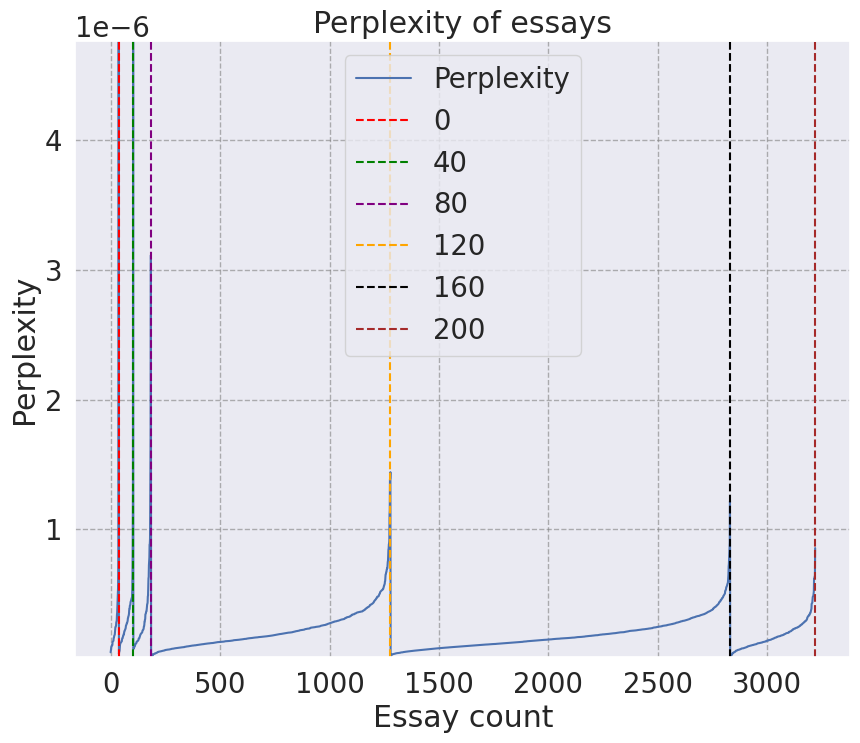

In [38]:
plotter.plot_perplexity_for_each_essay(big_df)

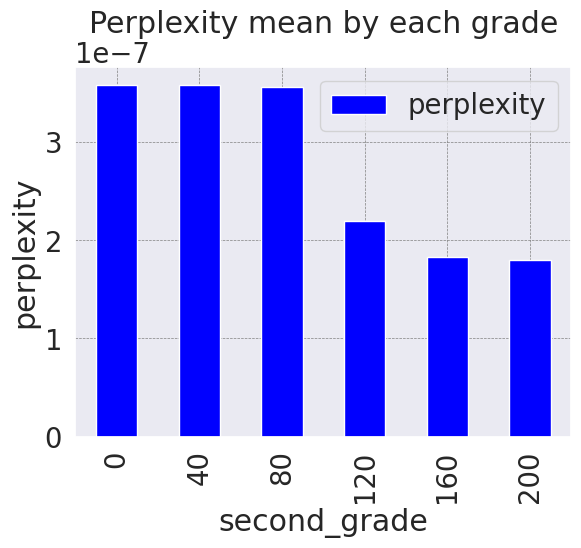

In [39]:
mean_by_grade_df = perplexity_calculator.calculate_perplexity_mean_for_each_grade(big_df)
plotter.plot_perplexity_mean_for_each_grade(mean_by_grade_df)

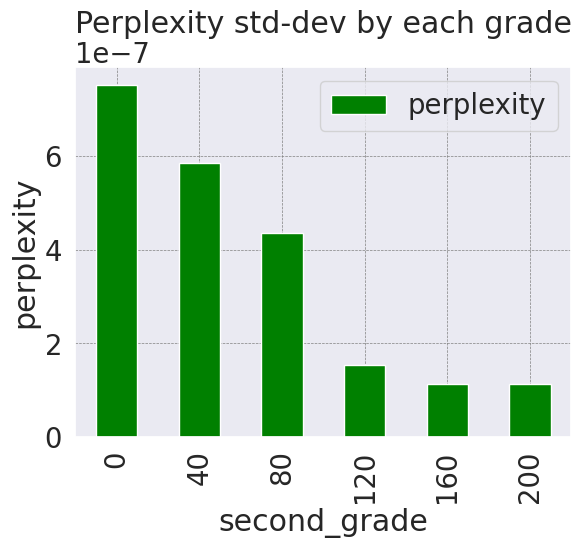

In [40]:
std_dev_by_grade_df = perplexity_calculator.calculate_perplexity_std_dev_for_each_grade(big_df)
plotter.plot_perplexity_std_dev_for_each_grade(std_dev_by_grade_df)

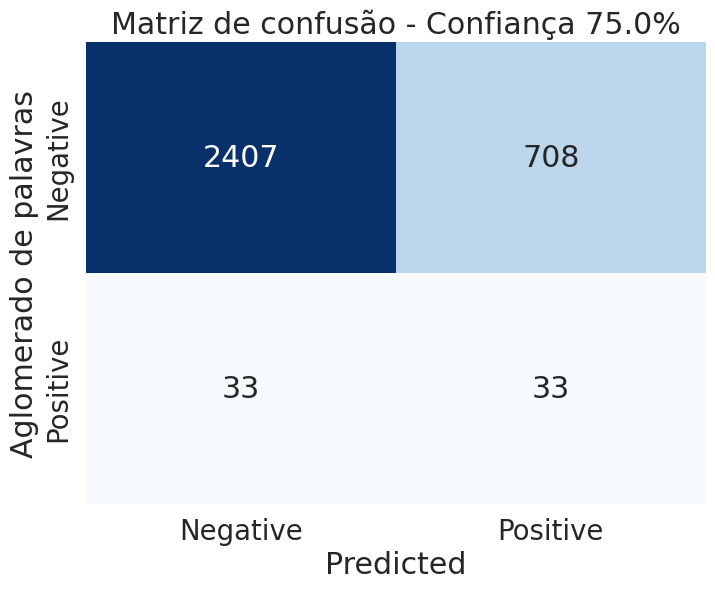

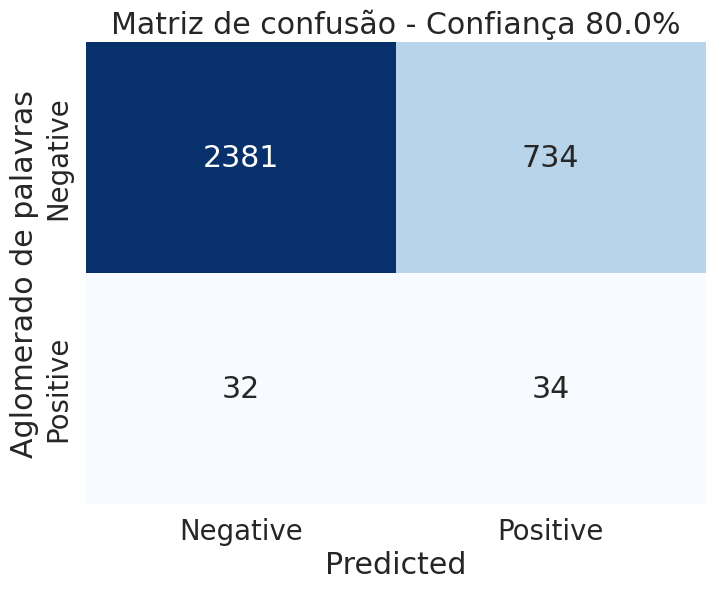

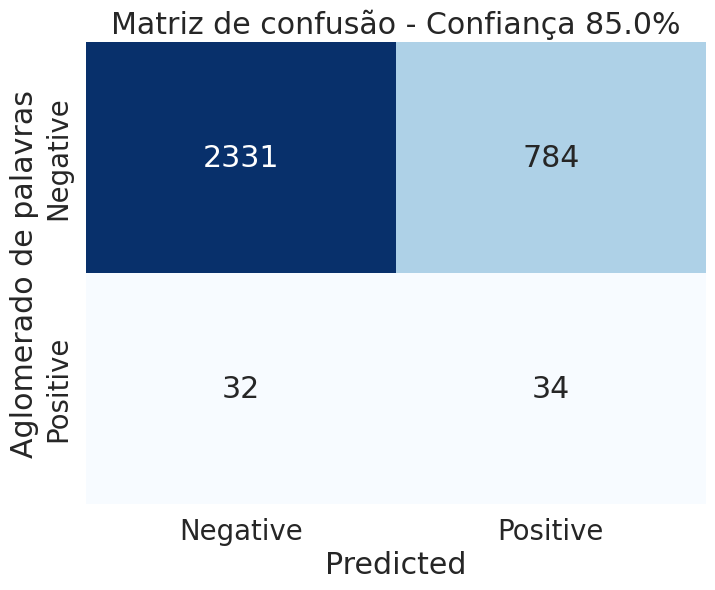

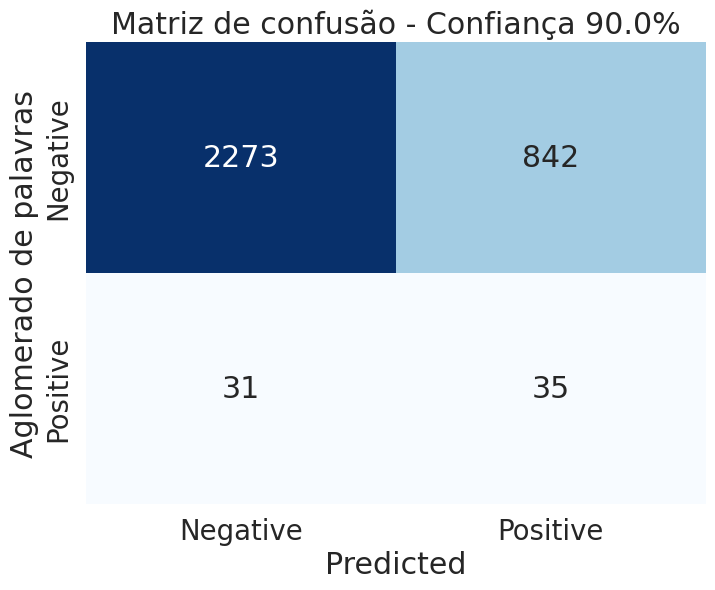

In [41]:
plotter.plot_confusion_matrix_for_confidence_intervals(big_df[big_df["second_grade"] != 0], confidence_intervals)

Usando a melhor configuração escolhida para o dataset inicial, neste caso, obtivemos uma acurácia de 77% para redações que não são aglomerados, e 50% para redações de nota 40 (possíveis aglomerados), um resultado quase igual ao executar a avaliação anterior.

Porém, neste caso, observando os demais intervalos, vemos, por exemplo, que o de 90% de confiança traz um aumento na acurácia da predição dos possíveis aglomerados (53%) e uma diminuição para as redações que não são aglomerados (73%).

### 2) Calcularemos qual é o intervalo que melhor se encaixa no dataset grande, e rodaremos a avaliação no dataset inicial.

In [42]:
grade_40_df = big_df[big_df["second_grade"] == 40]
grade_40_df

confidence_levels = [0.4, 0.5, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9]

confidence_intervals = perplexity_calculator.calculate_confidence_intervals(grade_40_df,confidence_levels)
confidence_intervals

40.0% confidence interval: (0.0000003198, 0.0000003958)
50.0% confidence interval: (0.0000003089, 0.0000004067)
60.0% confidence interval: (0.0000002967, 0.0000004189)
65.0% confidence interval: (0.0000002900, 0.0000004257)
70.0% confidence interval: (0.0000002825, 0.0000004332)
75.0% confidence interval: (0.0000002741, 0.0000004415)
80.0% confidence interval: (0.0000002645, 0.0000004512)
85.0% confidence interval: (0.0000002528, 0.0000004629)
90.0% confidence interval: (0.0000002375, 0.0000004782)


{0.4: (3.19833391657257e-07, 3.9583551316985515e-07),
 0.5: (3.089229790349955e-07, 4.067459257921167e-07),
 0.6: (2.967432488264191e-07, 4.1892565600069306e-07),
 0.65: (2.89951462775603e-07, 4.2571744205150915e-07),
 0.7: (2.824954515815132e-07, 4.3317345324559894e-07),
 0.75: (2.741339072086184e-07, 4.4153499761849375e-07),
 0.8: (2.64471831063216e-07, 4.511970737638962e-07),
 0.85: (2.5278731540253587e-07, 4.628815894245763e-07),
 0.9: (2.3750790318644215e-07, 4.7816100164067e-07)}

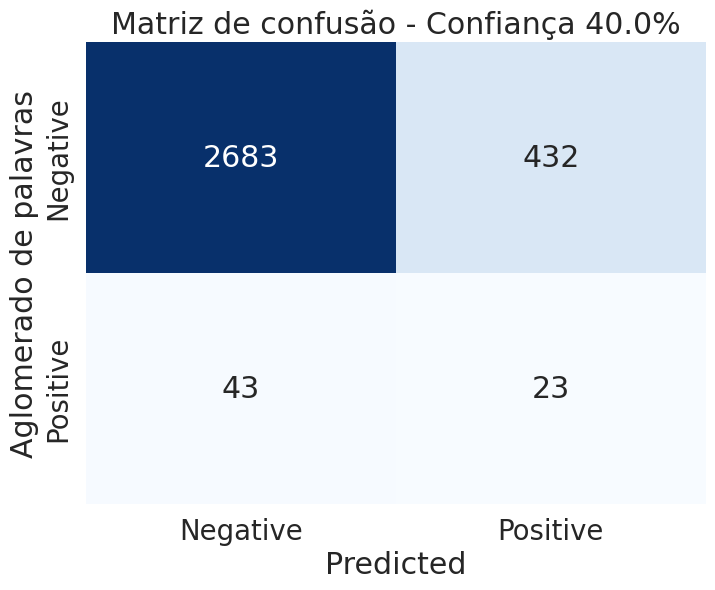

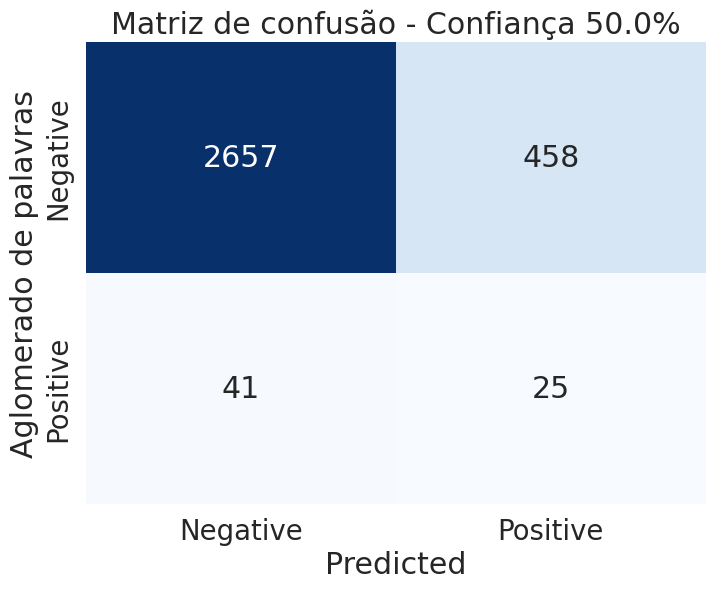

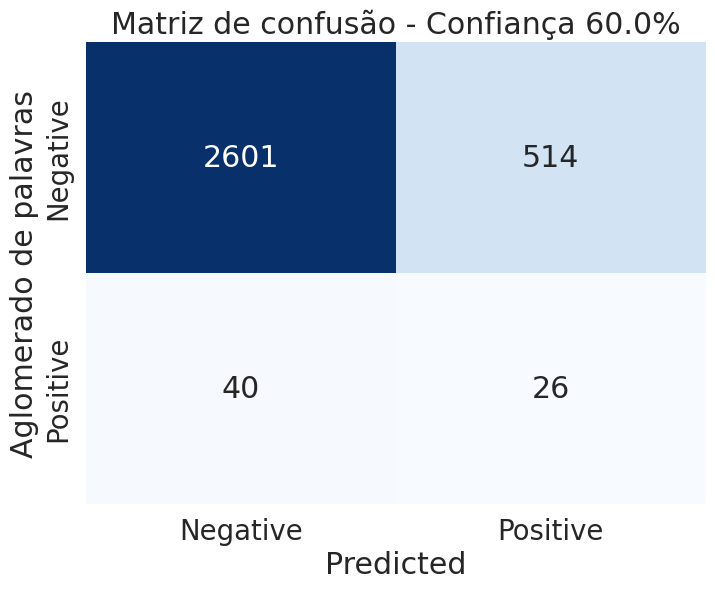

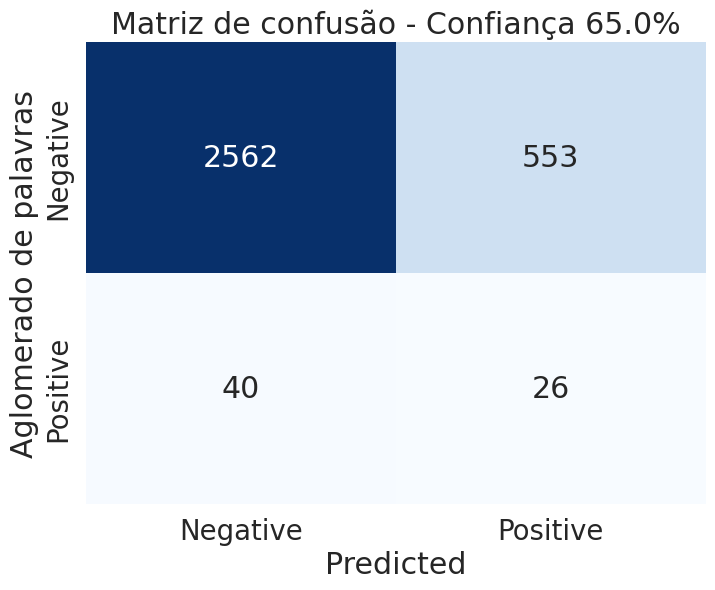

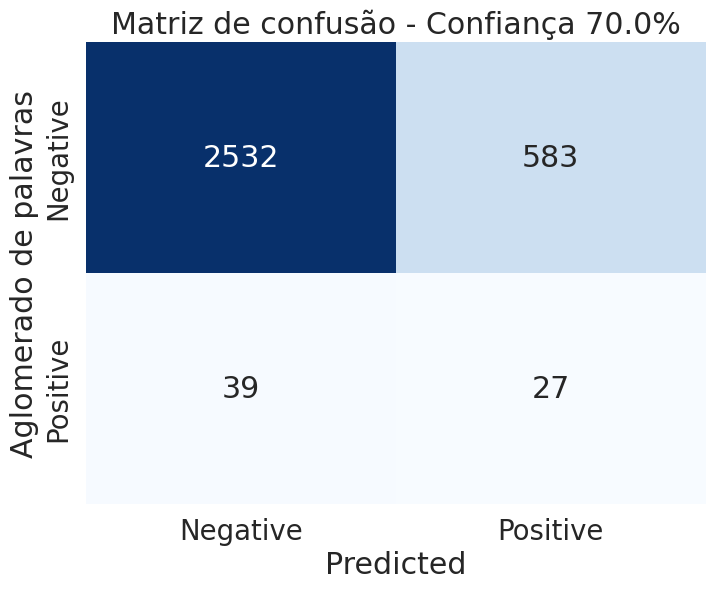

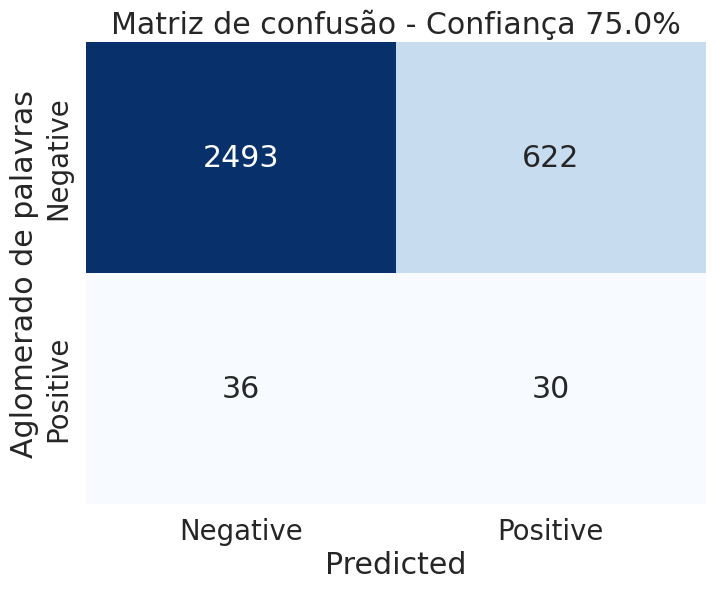

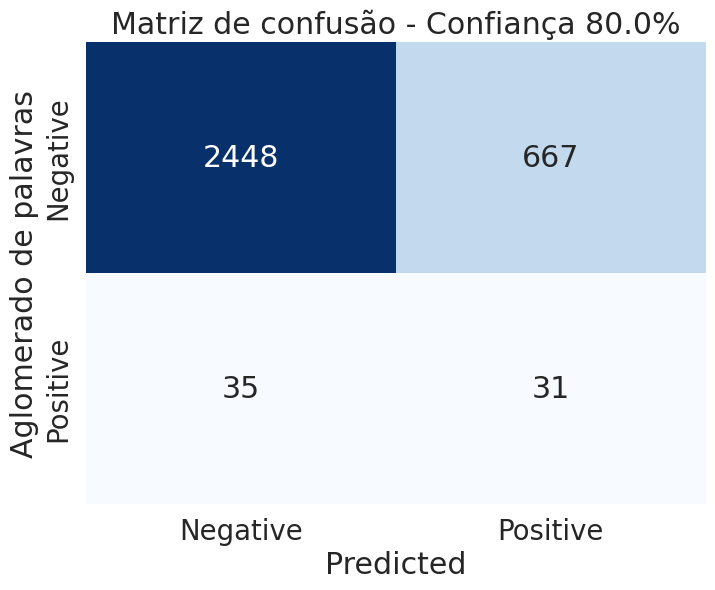

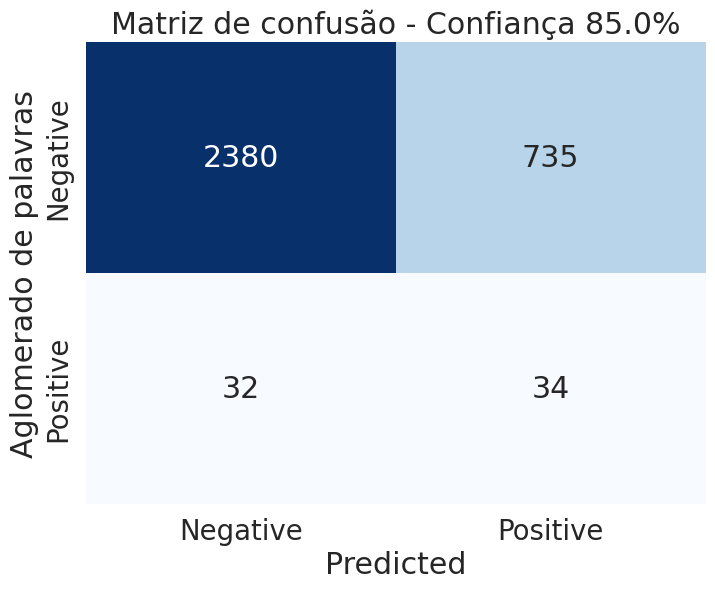

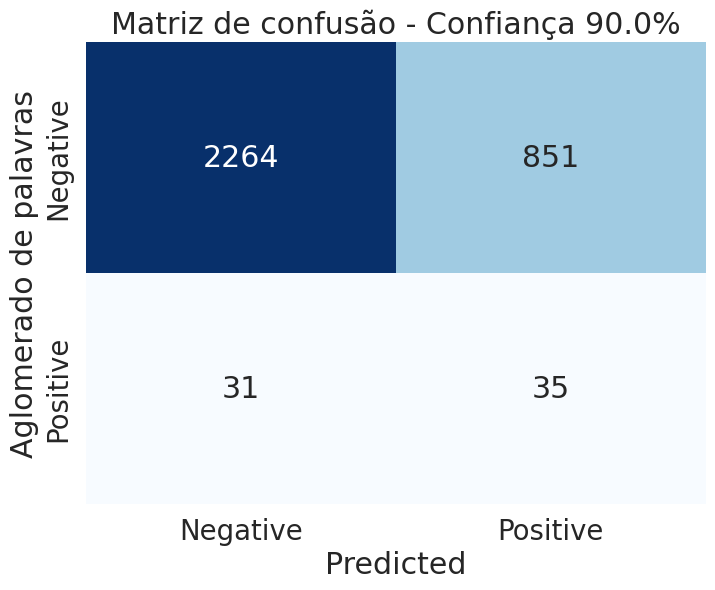

In [43]:
plotter.plot_confusion_matrix_for_confidence_intervals(big_df[big_df["second_grade"] != 0], confidence_intervals)

No caso do dataset grande, como podemos observar acima, o intervalo que melhor captura as redações que são possíveis aglomerados é o de 90% de confiança.
Utilizando ele, obtém-se uma acurácia de 72% para redações que não são aglomerados e 53% para as que são possíveis aglomerados.

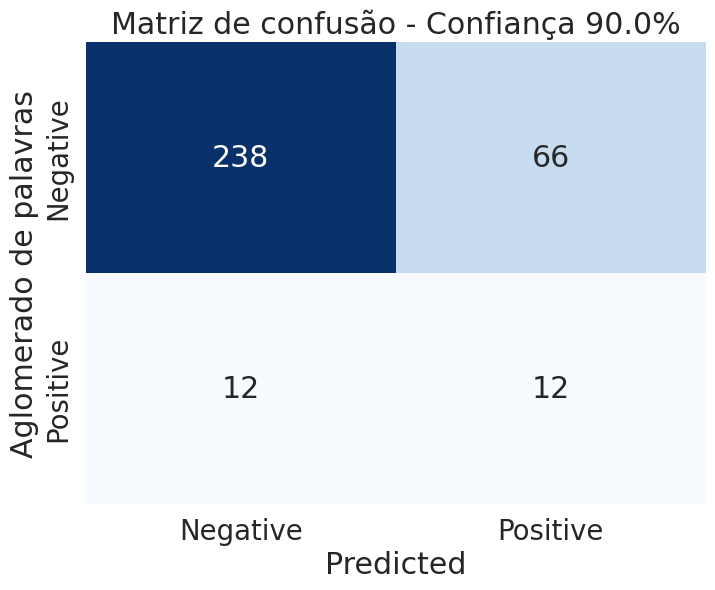

In [44]:
plotter.plot_confusion_matrix_for_confidence_intervals(df[df["second_grade"] != 0], {0.9: confidence_intervals[0.9]})

Utilizando o intervalo de confiança 90% obtido a partir do dataset grande, obtivemos um resultado quase igual ao da primeira avaliação, pois o limite inferior do intervalo foi muito próximo ao primeiro:

Para as redações de nota 40, houve um acerto de 50%.
Já para as demais, o acerto foi de 78%.

Dessa forma, o intervalo que será usado no nosso pipeline será este último:

(0.0000002375, +inf)